
Summary (degree = 14, m = 100)
Condition number cond(A) = 2.271777e+10, cond(A^T A) = 1.978148e+18

Residual norms ||A x - f||:
  MGS_QR         : 2.229784e-06  rel_err_to_truth = 4.747e-02
  Householder_QR : 2.116653e-06  rel_err_to_truth = 5.779e-09
  SVD            : 2.116654e-06  rel_err_to_truth = 3.801e-11
  NormalEq       : 1.812443e-04  rel_err_to_truth = 1.279e+00
  Truth          : 2.116651e-06  rel_err_to_truth = 0.000e+00

Top 6 singular values of A: [13.715525  6.679826  2.457826  0.77542   0.216909  0.054381]


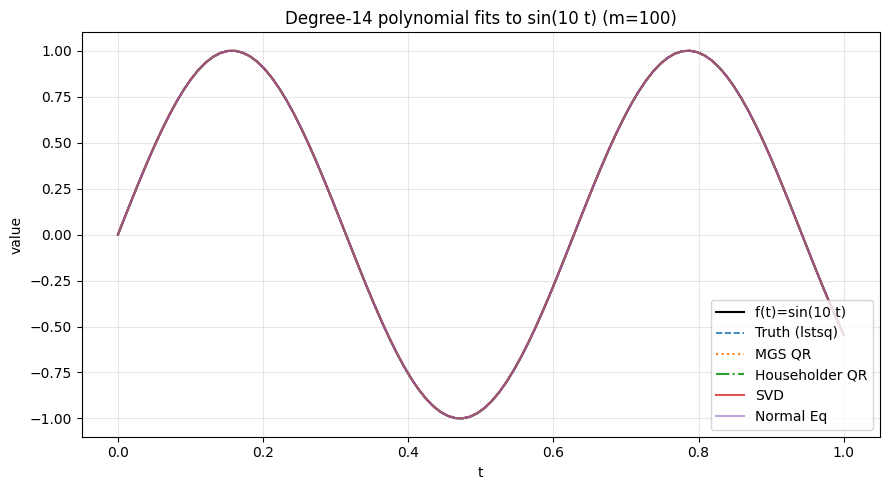


First 8 coefficients (truth): [   -0.          10.00006     -0.003149  -166.610619    -0.295948
   830.456537    55.223896 -2392.044069]
First 8 coeffs: MGS: [   -0.          10.00012     -0.006704  -166.526135    -1.363308
   838.640347    14.192343 -2251.454195]
First 8 coeffs: Householder: [   -0.          10.00006     -0.003149  -166.610619    -0.295949
   830.456541    55.223882 -2392.044032]
First 8 coeffs: SVD: [   -0.          10.00006     -0.003149  -166.610619    -0.295948
   830.456537    55.223896 -2392.044069]
First 8 coeffs: NormalEq: [    0.000026     9.991983     0.389948  -174.116011    72.867477
   423.43927   1383.358384 -4693.282606]


In [12]:
# lsq_compare.py
# Problem 5 — comparing least squares methods (MGS, Householder, SVD, Normal eqns)
# Run with: python lsq_compare.py

import numpy as np
import matplotlib.pyplot as plt
import math

np.set_printoptions(precision=6, suppress=True)

# ----------------------------
# Utilities
# ----------------------------
def back_substitution(R, y, tol=1e-15):
    """Solve upper-triangular R x = y by back substitution.
       R is (n,n), y is length n (or shape (n,)).
    """
    n = R.shape[0]
    x = np.zeros(n, dtype=float)
    for i in range(n-1, -1, -1):
        denom = R[i, i]
        if abs(denom) < tol:
            # singular diagonal — set to zero (cannot uniquely solve)
            x[i] = 0.0
            continue
        x[i] = (y[i] - np.dot(R[i, i+1:], x[i+1:])) / denom
    return x

# ----------------------------
# (a) Modified Gram-Schmidt
# ----------------------------
def modified_gram_schmidt(A):
    """Return Q (m x n) and R (n x n) from A (m x n) using MGS.
       Columns of Q are orthonormal (or zero if dependent).
    """
    A = A.copy().astype(float)
    m, n = A.shape
    Q = np.zeros((m, n), dtype=float)
    R = np.zeros((n, n), dtype=float)
    V = A.copy()
    for k in range(n):
        R[k, k] = np.linalg.norm(V[:, k])
        if R[k, k] == 0.0:
            Q[:, k] = 0.0
            continue
        Q[:, k] = V[:, k] / R[k, k]
        for j in range(k+1, n):
            R[k, j] = Q[:, k].dot(V[:, j])
            V[:, j] = V[:, j] - R[k, j] * Q[:, k]
    return Q, R

# ----------------------------
# (b) Householder QR
# ----------------------------
def householder_qr(A):
    """Compute Householder QR factorization.
       Returns R (n x n), list of Householder vectors 'vs' (each length m, with zeros above k),
       and the modified A (upper-triangular in top n x n).
       This implementation follows the typical algorithm and stores full-length reflectors.
    """
    A = A.copy().astype(float)
    m, n = A.shape
    vs = []
    for k in range(n):
        # vector to reflect
        x = A[k:, k].copy()
        normx = np.linalg.norm(x)
        if normx == 0:
            v = np.zeros_like(x)
            vs.append(np.zeros(m))
            continue
        # choose sign to avoid cancellation
        sign = 1.0 if x[0] >= 0 else -1.0
        e1 = np.zeros_like(x); e1[0] = 1.0
        v_small = x + sign * normx * e1
        v_small = v_small / np.linalg.norm(v_small)
        # apply reflection to A[k:, k:]
        A[k:, k:] -= 2.0 * np.outer(v_small, v_small.dot(A[k:, k:]))
        # store full-length vector with zeros above k
        v_full = np.zeros(m, dtype=float)
        v_full[k:] = v_small
        vs.append(v_full)
    R = np.triu(A[:n, :n])
    return R, vs, A

def apply_householders_to_vector(vs, b):
    """Apply Householder reflections (stored as full-length vectors in vs)
       in the same order they were produced to vector b:
       b <- (I - 2 v_k v_k^T) ... (I - 2 v_1 v_1^T) b
    """
    b = b.copy().astype(float)
    for v in vs:
        if np.linalg.norm(v) == 0:
            continue
        b -= 2.0 * v * (v.dot(b))
    return b

# ----------------------------
# (c) SVD solver (pseudo-inverse)
# ----------------------------
def svd_solve(A, b, rcond=None):
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    if rcond is None:
        tol = np.max(A.shape) * np.finfo(float).eps * np.max(s)
    else:
        tol = rcond
    s_inv = np.array([1.0/si if si > tol else 0.0 for si in s])
    return (Vt.T * s_inv).dot(U.T.dot(b))

# ----------------------------
# (d) Normal equations solver
# ----------------------------
def normal_eq_solve(A, b):
    ATA = A.T.dot(A)
    ATb = A.T.dot(b)
    # try solve; if ill-conditioned, use lstsq as fallback
    try:
        x = np.linalg.solve(ATA, ATb)
    except np.linalg.LinAlgError:
        x, *_ = np.linalg.lstsq(ATA, ATb, rcond=None)
    return x

# ----------------------------
# Problem setup and run
# ----------------------------
def main():
    # data
    m = 100
    t = np.linspace(0.0, 1.0, m)
    f = np.sin(10.0 * t)

    deg = 14
    n = deg + 1

    # design matrix (Vandermonde: columns [1, t, t^2, ..., t^deg])
    A = np.vander(t, N=n, increasing=True)  # shape (m, n)

    # reference "truth" via numpy lstsq (like MATLAB backslash)
    x_truth, residuals, rank, svals = np.linalg.lstsq(A, f, rcond=None)
    y_truth = A.dot(x_truth)

    # (a) MGS
    Q_mgs, R_mgs = modified_gram_schmidt(A)
    y_mgs_rhs = Q_mgs.T.dot(f)
    x_mgs = back_substitution(R_mgs, y_mgs_rhs)
    y_mgs = A.dot(x_mgs)

    # (b) Householder
    R_house, vs_house, A_after = householder_qr(A)
    b_t = apply_householders_to_vector(vs_house, f)  # b transformed
    y_house_rhs = b_t[:n]
    x_house = back_substitution(R_house, y_house_rhs)
    y_house = A.dot(x_house)

    # (c) SVD
    x_svd = svd_solve(A, f)
    y_svd = A.dot(x_svd)

    # (d) Normal equations
    x_normal = normal_eq_solve(A, f)
    y_normal = A.dot(x_normal)

    # Residual norms and relative errors to truth
    def rel_error(xref, x):
        return np.linalg.norm(x - xref) / (np.linalg.norm(xref) + 1e-16)

    solutions = {
        'MGS_QR': x_mgs,
        'Householder_QR': x_house,
        'SVD': x_svd,
        'NormalEq': x_normal,
        'Truth': x_truth
    }

    residuals = {k: np.linalg.norm(A.dot(v) - f) for k, v in solutions.items()}
    rel_errors = {k: (0.0 if k == 'Truth' else rel_error(x_truth, v)) for k, v in solutions.items()}

    # singular values and condition numbers
    U, s_all, Vt = np.linalg.svd(A, full_matrices=False)
    cond_A = np.linalg.cond(A)
    cond_ATA = np.linalg.cond(A.T.dot(A))

    # print summary
    print("\nSummary (degree = {}, m = {})".format(deg, m))
    print("Condition number cond(A) = {:.6e}, cond(A^T A) = {:.6e}".format(cond_A, cond_ATA))
    print("\nResidual norms ||A x - f||:")
    for k in residuals:
        print("  {:15s}: {:.6e}  rel_err_to_truth = {:.3e}".format(k, residuals[k], rel_errors[k]))
    print("\nTop 6 singular values of A:", s_all[:6])

    # plot
    plt.figure(figsize=(9,5))
    plt.plot(t, f, label='f(t)=sin(10 t)', color='black', linewidth=1.5)
    plt.plot(t, y_truth, '--', label='Truth (lstsq)', linewidth=1.2)
    plt.plot(t, y_mgs, ':', label='MGS QR')
    plt.plot(t, y_house, '-.', label='Householder QR')
    plt.plot(t, y_svd, '-', label='SVD', alpha=0.8)
    plt.plot(t, y_normal, '-', label='Normal Eq', alpha=0.6)
    plt.legend(loc='lower right')
    plt.title('Degree-{} polynomial fits to sin(10 t) (m={})'.format(deg, m))
    plt.xlabel('t'); plt.ylabel('value')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # If you want, print coefficient vectors (short)
    print("\nFirst 8 coefficients (truth):", x_truth[:8])
    print("First 8 coeffs: MGS:", x_mgs[:8])
    print("First 8 coeffs: Householder:", x_house[:8])
    print("First 8 coeffs: SVD:", x_svd[:8])
    print("First 8 coeffs: NormalEq:", x_normal[:8])

if __name__ == '__main__':
    main()
